# Projeto: Predição de Violência com Machine Learning

**Objetivo**

Este projeto visa prever o tipo de violência (física ou psicológica) com base em registros de ocorrências, visando auxiliar na prevenção e promover a ação de políticas públicas.

Dados Utilizados
- Fonte: Banco de dados Sinan
- Registros: 564.432 entradas
- Colunas: {
  ANO,
  NU_IDADE_N,
  CS_RACA ,
  CS_ESCOL_N,
  UF: PE,
  LOCAL_OCOR,
  TIPO_RELACAO,
  AUTOR_SEXO,
  OUT_VEZES
}


# Pre Processamento dos dados





Nessa etapa foi feita a:

- importaçao dos dados

- Remoção de colunas irrelevantes para o modelo.

- Preenchimento de valores nulos com a mediana e moda.

- Conversão de variáveis.

- Aplicação do OneHotEncoder e LabelEncoded.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# importando a base e verificando o numero de dados inicias
df_dados_violencia = pd.read_csv("/content/SINAN-VIOL-2017-2019.csv", low_memory=False)
df_dados_violencia.shape


(1063056, 161)

### Seleção das Colunas Relevantes e remoçao da irrelevantes

A base de dados contém aproximadamente 161 colunas. Após uma análise exploratória, identificamos que apenas uma parte dessas variáveis é realmente relevante para o contexto da violência contra a mulher. Sendo assim, optamos por manter apenas as colunas que apresentam relação direta com o problema  estudado, descartando atributos irrelevantes.

In [ ]:
# pegando as colunas mias relevantes
df_dados_violencia = df_dados_violencia[['level_0', 'level_1','DT_NOTIFIC','DT_OCOR', 'DT_NASC', 'NU_IDADE_N', 'CS_SEXO',
                                         'CS_RACA', 'CS_ESCOL_N', 'LOCAL_OCOR', 'LES_AUTOP', 'VIOL_FISIC', 'VIOL_PSICO',
                                         'VIOL_TORT', 'VIOL_SEXU', 'SEX_ASSEDI', 'SEX_ESTUPR', 'SEX_EXPLO', 'SEX_PORNO',
                                         'SEX_OUTRO', 'REL_PAI', 'REL_MAE', 'REL_PAD', 'REL_MAD', 'REL_CONJ', 'REL_EXCON',
                                         'REL_NAMO', 'REL_EXNAM', 'REL_FILHO', 'REL_IRMAO', 'REL_CONHEC', 'REL_DESCO',
                                         'AUTOR_SEXO', 'OUT_VEZES']]

# Renomenando as coluans leevel_0 para UF e level_1 para ANO
df_dados_violencia.rename(columns = {'level_0': 'UF', 'level_1': 'ANO'}, inplace = True)

<ipython-input-2-7033b7e05e33>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dados_violencia.rename(columns = {'level_0': 'UF', 'level_1': 'ANO'}, inplace = True)


A base de dados original contempla diversos casos de violência. No entanto, como o objetivo deste projeto é identificar especificamente os tipos de violência física e/ou psicológica sofridas por mulheres, foi necessário realizar um filtro nos dados para considerar apenas os registros que atendem a esses critérios.

In [ ]:
df_dados_violencia = df_dados_violencia[df_dados_violencia['CS_SEXO']=='F'] # Pegando apenas os registros de mulheres
df_dados_violencia = df_dados_violencia[df_dados_violencia['LES_AUTOP']!=1]
df_dados_violencia.drop(['CS_SEXO', 'LES_AUTOP', 'DT_NOTIFIC'], axis = 1, inplace = True) # removendo algumas colunas irrelevantes
df_dados_violencia.dropna(subset=['DT_OCOR'], inplace = True) # Remove os registros sem data de ocorrencia


# Conversão de tipos
df_dados_violencia['UF'] = df_dados_violencia['UF'].astype('category')
df_dados_violencia['ANO'] = df_dados_violencia['ANO'].astype('category')
df_dados_violencia['REL_PAI'] = pd.to_numeric(df_dados_violencia['REL_PAI'], errors='coerce')
df_dados_violencia['DT_NASC'] = pd.to_datetime(df_dados_violencia['DT_NASC'])
df_dados_violencia['DT_OCOR'] = pd.to_datetime(df_dados_violencia['DT_OCOR'])

<ipython-input-3-8ab9f2b72779>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dados_violencia.drop(['CS_SEXO', 'LES_AUTOP', 'DT_NOTIFIC'], axis = 1, inplace = True) # removendo algumas colunas irrelevantes


In [ ]:
# Registros sem idade e sem data de nasc.
sidade_snasc = df_dados_violencia[df_dados_violencia['NU_IDADE_N'].isna() & df_dados_violencia['DT_NASC'].isna()]

print(f'Há {len(sidade_snasc)} registros sem idade e sem a data de nascimento.')

Há 153 registros sem idade e sem a data de nascimento.


In [ ]:
# Excluir os registros sem idade e sem data de nascimento
df_dados_violencia = df_dados_violencia[(df_dados_violencia['NU_IDADE_N'].notnull() |
                                         df_dados_violencia['DT_NASC'].notnull())]

### Padronizaçao da Idade

De acordo com o dicionário de dados do SINAN (Sistema de Informação de Agravos de Notificação), a variável que representa a idade segue uma codificação específica:

O primeiro dígito indica a unidade de tempo:

1 → horas

2 → dias

3 → meses

4 → anos

Os dois últimos dígitos representam a quantidade.
Por exemplo:

3009 → 9 meses

4018 → 18 anos

com isso para padronizar esse dado vamos coloca-lo em anos.


In [ ]:
# Colocar idade em anos
def calcula_idade(idade, nasc, ocor):
    if idade != idade: # Retorna True caso idade = nan
        return ocor.year - nasc.year - ((ocor.month, ocor.day) < (nasc.month, nasc.day))
    elif (idade > 4000):
        return idade - 4000
    elif (idade > 3000):
        return (idade - 3000)/12
    elif (idade > 1000):
        return 0
    else:
        return idade

df_dados_violencia['NU_IDADE_N'] = df_dados_violencia.apply(lambda row: calcula_idade(row['NU_IDADE_N'],
                                                                                      row['DT_NASC'],
                                                                                      row['DT_OCOR']), axis=1)

df_dados_violencia['NU_IDADE_N'].isnull().sum()

np.int64(0)

### Mapeamento de colunas

Foi feito o  mapeamento de algumas colunas para deixar os dados mais interpretaveis e posteriormente facilitar o seu uso.

In [ ]:
df_dados_violencia['CS_RACA'] = df_dados_violencia['CS_RACA'].astype('category')

mapping = {1 : 'Branca',
           2 : 'Preta',
           3 : 'Amarela',
           4 : 'Parda',
           5 : 'Indígena',
           9 : 'Ignorado'}

df_dados_violencia['CS_RACA'] = df_dados_violencia['CS_RACA'].map(mapping)
df_dados_violencia['CS_RACA'].value_counts()

,count
CS_RACA,
Parda,235939
Branca,216549
Ignorado,50694
Preta,49199
Indígena,5129
Amarela,4138


In [ ]:
df_dados_violencia['CS_ESCOL_N'] = df_dados_violencia['CS_ESCOL_N'].astype('category')

mapping = {0 : 'Não alfabetizada',
           1 : '1ª a 4ª série incompleta do EF',
           2 : '4ª série completa do EF',
           3 : '5ª à 8ª série incompleta do EF',
           4 : 'Ensino fundamental completo',
           5 : 'Ensino médio incompleto',
           6 : 'Ensino médio completo',
           7 : 'Educação superior incompleta',
           8 : 'Educação superior completa',
           9 : 'Ignorado ou em branco',
           10 : 'Não se aplica'}

df_dados_violencia['CS_ESCOL_N'] = df_dados_violencia['CS_ESCOL_N'].map(mapping)
df_dados_violencia['CS_ESCOL_N'].value_counts()

,count
CS_ESCOL_N,
Ignorado ou em branco,143307
5ª à 8ª série incompleta do EF,79793
Ensino médio completo,76710
Não se aplica,62734
Ensino médio incompleto,49236
Ensino fundamental completo,36081
1ª a 4ª série incompleta do EF,35681
4ª série completa do EF,18183
Educação superior completa,15610


In [ ]:
df_dados_violencia['LOCAL_OCOR'] = df_dados_violencia['LOCAL_OCOR'].astype('category')

mapping = {1 : 'Residência',
           2 : 'Habitação coletiva',
           3 : 'Escola',
           4 : 'Local de prática esportiva',
           5 : 'Bar ou similar',
           6 : 'Via publica',
           7 : 'Comércio/Serviços',
           8 : 'Industrias/ construção',
           9 : 'Outro'}

df_dados_violencia['LOCAL_OCOR'] = df_dados_violencia['LOCAL_OCOR'].map(mapping)
df_dados_violencia['LOCAL_OCOR'].value_counts()

,count
LOCAL_OCOR,
Residência,352502
Via publica,75492
Outro,33040
Bar ou similar,11541
Comércio/Serviços,9504
Escola,8957
Habitação coletiva,4412
Local de prática esportiva,1303
Industrias/ construção,606


### Criação de novas colunas

Para facilitar a análise e modelagem dos dados, criamos uma nova coluna chamada TIPO_VIOLENCIA, baseada nas variáveis que indicam os tipos de violência presentes no registro.

In [ ]:
def categorizar_violencia_simplificada(row):
    if row['VIOL_FISIC'] == 1:
        return 'física'
    elif row['VIOL_PSICO'] == 1:
        return 'psicológica'
    elif (
        row['VIOL_SEXU'] == 1 or row['SEX_ASSEDI'] == 1 or
        row['SEX_ESTUPR'] == 1 or row['SEX_EXPLO'] == 1 or
        row['SEX_PORNO'] == 1 or row['SEX_OUTRO'] == 1 or
        row['VIOL_TORT'] == 1
    ):
        return 'outros'
    else:
        return 'nenhuma'

df_dados_violencia['TIPO_VIOLENCIA'] = df_dados_violencia.apply(categorizar_violencia_simplificada, axis=1)


Após a criação da variável TIPO_VIOLENCIA, que resume os diversos tipos de violência em uma única categoria, as colunas originais relacionadas à violência foram removidas por se tornarem redundantes.

In [ ]:
#Removendo os campos desnecessários

colunas_violencia = [
    'VIOL_FISIC', 'VIOL_PSICO', 'VIOL_TORT', 'VIOL_SEXU',
    'SEX_ASSEDI', 'SEX_ESTUPR', 'SEX_EXPLO', 'SEX_PORNO', 'SEX_OUTRO'
]

df_dados_violencia.drop(columns=colunas_violencia, inplace=True)


Para consolidar as diversas possíveis relações entre a vítima e o agressor, foi criada a variável TIPO_RELACAO. A nova coluna resume as colunas binárias originais em uma única categoria. ( basicamente o mesmo que fizemos na coluna TIPO_VIOLENCIA)

In [ ]:
def categorizar_relacao(row):
    grupos = set()

    # Família
    if row['REL_PAI'] == 1 or row['REL_MAE'] == 1 or row['REL_PAD'] == 1 or row['REL_MAD'] == 1 or \
       row['REL_FILHO'] == 1 or row['REL_IRMAO'] == 1:
        grupos.add('familiar')

    # Cônjuge e ex-cônjuge
    if row['REL_CONJ'] == 1 or row['REL_EXCON'] == 1:
        grupos.add('cônjuge')

    # Namorado(a) e ex
    if row['REL_NAMO'] == 1 or row['REL_EXNAM'] == 1:
        grupos.add('namorado(a)')

    # Conhecido
    if row['REL_CONHEC'] == 1:
        grupos.add('conhecido(a)')

    # Desconhecido
    if row['REL_DESCO'] == 1:
        grupos.add('desconhecido(a)')

    if not grupos:
        return 'não informado'
    elif len(grupos) == 1:
        return list(grupos)[0]
    else:
        return 'múltiplas'

df_dados_violencia['TIPO_RELACAO'] = df_dados_violencia.apply(categorizar_relacao, axis=1)


In [ ]:
colunas_relacao = [
    'REL_PAI', 'REL_MAE', 'REL_PAD', 'REL_MAD',
    'REL_CONJ', 'REL_EXCON', 'REL_NAMO', 'REL_EXNAM',
    'REL_FILHO', 'REL_IRMAO', 'REL_CONHEC', 'REL_DESCO'
]

df_dados_violencia.drop(columns=colunas_relacao, inplace=True)


In [ ]:
# Convertendo algumas colunas para o tipo 'category'
df_dados_violencia['TIPO_VIOLENCIA'] = df_dados_violencia['TIPO_VIOLENCIA'].astype('category')
df_dados_violencia['TIPO_RELACAO'] = df_dados_violencia['TIPO_RELACAO'].astype('category')
df_dados_violencia['LOCAL_OCOR'] = df_dados_violencia['LOCAL_OCOR'].astype('category')

### Tratamento de valores ausentes

Para garantir que os modelos de machine learning funcione corretamente, foi realizado o preenchimento de valores ausentes nas colunas:

- Colunas categóricas (`CS_RACA`, `CS_ESCOL_N`, `LOCAL_OCOR`): foram preenchidas com a moda (valor mais frequente), por ser representativa do comportamento majoritário.
- Colunas numéricas (`AUTOR_SEXO`, `OUT_VEZES`): preenchidas com a mediana, que fornece um valor central confiável.

Após o preenchimento, foi realizada uma checagem para garantir que não restassem valores nulos.

In [ ]:
# Verificando quais colunas estao sem dados
df_dados_violencia.isnull().sum()

,0
UF,0
ANO,0
DT_OCOR,0
DT_NASC,8588
NU_IDADE_N,0
CS_RACA,2784
CS_ESCOL_N,26684
LOCAL_OCOR,67075
AUTOR_SEXO,1445
OUT_VEZES,4362


In [ ]:
# Preenchendo colunas categóricas com a moda
colunas_moda = ["CS_RACA", "CS_ESCOL_N", "LOCAL_OCOR"]
for coluna in colunas_moda:
    moda = df_dados_violencia[coluna].mode()[0]
    df_dados_violencia[coluna].fillna(moda, inplace=True)

# Preenchendo colunas numéricas com a mediana
colunas_mediana = ["AUTOR_SEXO", "OUT_VEZES"]
for coluna in colunas_mediana:
    mediana = df_dados_violencia[coluna].median()
    df_dados_violencia[coluna].fillna(mediana, inplace=True)

# Conferindo resultado
print(df_dados_violencia.isnull().sum())


UF                   0
ANO                  0
DT_OCOR              0
DT_NASC           8588
NU_IDADE_N           0
CS_RACA              0
CS_ESCOL_N           0
LOCAL_OCOR           0
AUTOR_SEXO           0
OUT_VEZES            0
TIPO_VIOLENCIA       0
TIPO_RELACAO         0
dtype: int64


<ipython-input-16-be2e1c1b9795>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_dados_violencia[coluna].fillna(moda, inplace=True)
<ipython-input-16-be2e1c1b9795>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

A coluna DT_NASC, responsável por armazenar a data de nascimento da vítima, apresentava uma grande quantidade de valores ausentes. Como a variável NU_IDADE_N já fornece a idade da vítima de forma consolidada, a DT_NASC foi considerada redundante e pouco informativa para os objetivos da análise. Por esse motivo, optou-se pela sua remoção.

In [ ]:
df_dados_violencia.drop(columns=['DT_NASC'], inplace=True)

In [ ]:

df_dados_violencia.isnull().sum()

,0
UF,0
ANO,0
DT_OCOR,0
NU_IDADE_N,0
CS_RACA,0
CS_ESCOL_N,0
LOCAL_OCOR,0
AUTOR_SEXO,0
OUT_VEZES,0
TIPO_VIOLENCIA,0


 coluna DT_OCOR, foi analisada e posteriormente removida. A decisão foi baseada nos seguintes fatores:

- Ausência significativa de dados nessa coluna em grande parte dos registros.
- Baixa relevância para os objetivos da modelagem.
- Simplificação do conjunto de dados para melhorar desempenho e interpretabilidade.


In [ ]:

df_dados_violencia['DT_OCOR'].head()
df_dados_violencia.drop(columns=['DT_OCOR'], inplace=True)

### Preparação dos Dados para Treinamento

Antes de treinar o modelo, realizamos as seguintes etapas:

1. **Separação da variável alvo (`TIPO_VIOLENCIA`)** dos preditores.
2. **Codificação de variáveis**:
   - `ANO`: codificado com `LabelEncoder`, convertendo valores categóricos para inteiros.
   - Variáveis categóricas nominais (UF, CS_RACA, CS_ESCOL_N, LOCAL_OCOR, TIPO_RELACAO) foram convertidas para variáveis binárias via OneHotEncoder.

3. **Divisão em conjuntos de treino e teste**:
   - 70% dos dados para treino e 30% para teste.
   - Uso do parâmetro `stratify=y` para manter a mesma proporção de classes nos dois conjuntos.

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# 1. Cópia de segurança dos dados
df = df_dados_violencia.copy()

# 2. Separar variável alvo (antes de aplicar qualquer transformação)
y = df['TIPO_VIOLENCIA']
X = df.drop(columns=['TIPO_VIOLENCIA'])

le = LabelEncoder()
X['ANO'] = le.fit_transform(X['ANO'])

# Lista de colunas para OneHotEncoder
colunas_onehot = [
    'UF',
    'CS_RACA',
    'CS_ESCOL_N',
    'LOCAL_OCOR',
    'TIPO_RELACAO'
]


# OneHot Encoding no resto das colulas
X = pd.get_dummies(X, columns=colunas_onehot, drop_first=True)


# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1000, stratify=y
)



# Treinamento do modelo





Após o pré-processamento dos dados, partimos para a etapa de treinamento dos modelos de machine learning. Nessa fase, o objetivo é encontrar o algoritimo que melhor consegue prever o tipo de violência sofrida com base nas informações presentes na base de dados.

aqui foram ultilizados algoritimos como:

- Random Forest

- Arvore de Decisao

- Rede Neural

- LightGBM

- XGBoost

## Algoritmos de aprendizagem

---



O Primeiro algoritimo ultilizado foi o Random Forest

In [ ]:
# imports

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,accuracy_score
from yellowbrick.classifier import ConfusionMatrix
import seaborn as sns
import lightgbm as lgb



In [ ]:
# Criando o modelo
modelo = RandomForestClassifier(
        max_depth=10, # numero de amostras minimas para dividir um no.
        min_samples_split=5, # define o numero minimo de amostras pra dividir um no.
        n_estimators=100, # numero de arvores da floresta
        random_state=42) # garente que os resultados sejam reprodutiveis
#Realizando o treinamento
modelo.fit(X_train, y_train)

# faz as previsoes com base nos dados de teste
y_pred = modelo.predict(X_test)

# impressao do relatorio com as metricas de avaliaçao.
print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred))


Relatório de Classificação:



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      física       0.79      0.95      0.87    115303
     nenhuma       0.79      0.64      0.71     17859
      outros       0.65      0.50      0.57     21011
 psicológica       0.00      0.00      0.00     15157

    accuracy                           0.78    169330
   macro avg       0.56      0.52      0.54    169330
weighted avg       0.70      0.78      0.74    169330



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


O primeiro modelo testado teve um ótimo desempenho na classe física, porém um desempenho nulo na classe psicológica. Com isso, iremos testar outros modelos e tentar identificar o real problema.

In [ ]:
# Criando o modelo
modelo = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

# treinamento
modelo.fit(X_train, y_train)

# faz as previsoes
y_pred = modelo.predict(X_test)

# impressao do relatorio com as metricas de avaliaçao.
print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      física       0.82      0.92      0.86    115303
     nenhuma       0.71      0.71      0.71     17859
      outros       0.57      0.60      0.58     21011
 psicológica       0.00      0.00      0.00     15157

    accuracy                           0.77    169330
   macro avg       0.52      0.56      0.54    169330
weighted avg       0.70      0.77      0.74    169330



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


A árvore de decisão teve o mesmo problema do modelo anterior, não identificando muito bem a classe psicológica.

In [ ]:
model_lgb = lgb.LGBMClassifier(
    objective='multiclass',
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    num_leaves = 63 ,
    scale_pos_weight=3,  # dizendo que a classe e mais importante

)
model_lgb.fit(X_train, y_train)

# 4. Avaliar
y_pred = model_lgb.predict(X_test)
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 395102, number of used features: 59
[LightGBM] [Info] Start training from score -0.384291
[LightGBM] [Info] Start training from score -2.249315
[LightGBM] [Info] Start training from score -2.086814
[LightGBM] [Info] Start training from score -2.413365
              precision    recall  f1-score   support

      física       0.83      0.93      0.88    115303
     nenhuma       0.79      0.76      0.77     17859
      outros       0.63      0.64      0.64     21011
 psicológica       0.54      0.07      0.13     15157

    accuracy                           0.80    169330
   macro avg       0.70  

O LGBMClassifier foi o que apresentou a maior acurácia até o momento, porém ele ainda não consegue definir muito bem a classe psicológica.

In [ ]:
rede_neural_violencia = MLPClassifier( hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        max_iter=100,
        random_state=42)
rede_neural_violencia.fit(X_train, y_train)

y_pred = rede_neural_violencia.predict(X_test)

# impressao do relatorio com as metricas de avaliaçao.
print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Relatório de Classificação:

              precision    recall  f1-score   support

      física       0.83      0.92      0.88    115303
     nenhuma       0.79      0.74      0.76     17859
      outros       0.62      0.64      0.63     21011
 psicológica       0.47      0.08      0.13     15157

    accuracy                           0.79    169330
   macro avg       0.68      0.60      0.60    169330
weighted avg       0.77      0.79      0.77    169330



Apesar de os modelos apresentarem uma acurácia legal, eles ainda não estão conseguindo identificar muito bem a classe psicológica, o que indica um desbalanceamento muito grande entre as classes. Vamos, inicialmente, analisar a matriz de confusão para ver a quantidade de acertos e erros de cada classe."

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


0.7941357113329003

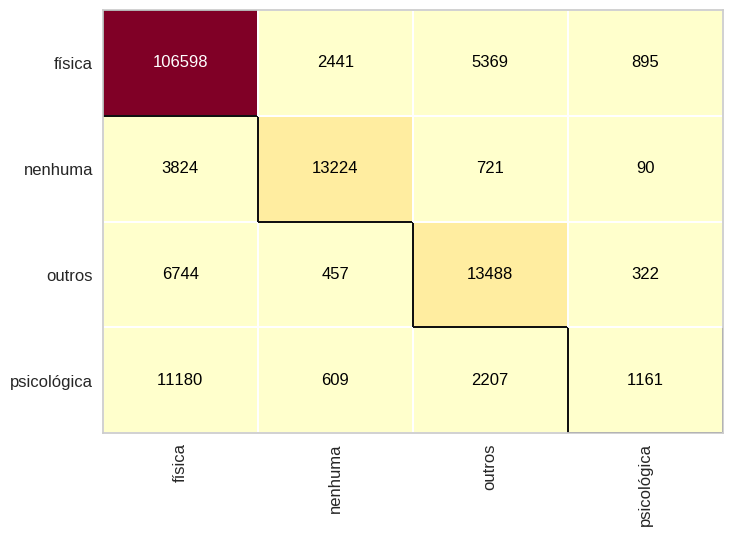

In [ ]:
mc = ConfusionMatrix(rede_neural_violencia) # criando um visualizados de matriz de confusao
mc.fit(X_train, y_train) # treinando o modelo com os dados registrados
mc.score(X_test, y_test) # mostra as metricas

Ao verificar a matriz de confusão, já é possível perceber que, de fato, a classe psicológica possui um número muito pequeno de dados. Vamos verificar isso graficamente.

<Axes: xlabel='TIPO_VIOLENCIA', ylabel='count'>

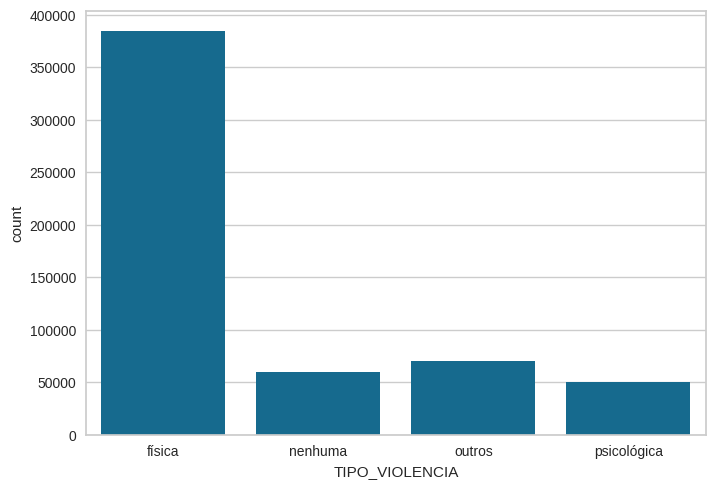

In [ ]:
# verificando de forma grafica o desbalanceamento
sns.countplot(x='TIPO_VIOLENCIA', data=df)

No gráfico acima, conseguimos identificar que, de fato, as classes possuem um desbalanceamento muito grande. Com isso, vamos aplicar uma técnica de balanceamento de dados chamada SMOTE e depois tentar rodar os modelos novamente.

## Balanceamento dos dados - (psicologica);



Conforme visto anteriormente, a classe psicológica não está sendo bem identificada. Para resolver o problema, vamos implementar o SMOTE para fazer o balanceamento dos dados. O SMOTE será implementado apenas nos dados de treinamento para evitar o problema de vazamento de dados ('data leakage').

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train) ## aplicado apenas nos dados de treino

In [ ]:
X_train_resampled.shape, y_train_resampled.shape , X.shape, y.shape # usado apena pra poder visualizar o quando a base cresceu

((628773, 59), (628773,), (564432, 59), (564432,))

<Axes: xlabel='count', ylabel='TIPO_VIOLENCIA'>

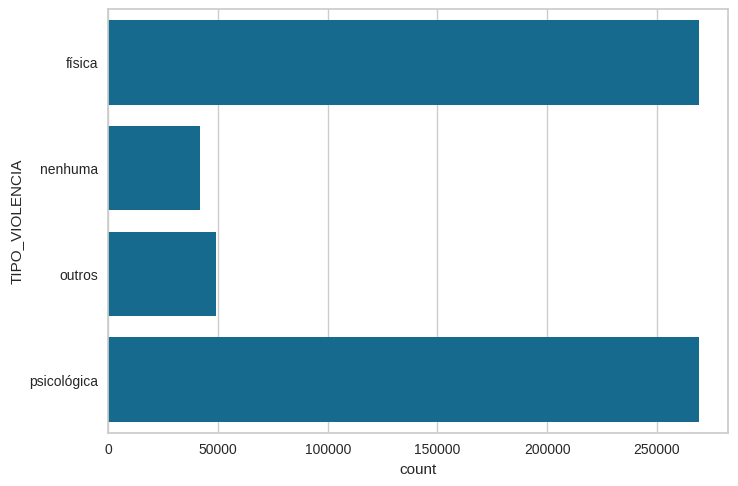

In [ ]:
sns.countplot( data=y_train_resampled) # verificar em forma grafica o balanceamento

## Algoritimos de Aprendizagem - pos balancemento classe (psicologica)


pós o balanceamento da classe psicológica, utilizei alguns algoritmos para verificar se haverá melhora ou diminuição na precisão e acurácia. Com base nos resultados, tomaremos novas medidas.

In [ ]:
modelo = RandomForestClassifier(max_depth=10,
        min_samples_split=5,
        n_estimators=100,
        random_state=42)
modelo.fit(X_train_resampled, y_train_resampled)

y_pred = modelo.predict(X_test)

print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred))

Relatório de Classificação:

              precision    recall  f1-score   support

      física       0.84      0.72      0.78    115303
     nenhuma       0.81      0.57      0.67     17859
      outros       0.74      0.10      0.18     21011
 psicológica       0.17      0.62      0.27     15157

    accuracy                           0.62    169330
   macro avg       0.64      0.50      0.47    169330
weighted avg       0.76      0.62      0.65    169330



In [ ]:
model_lgb = lgb.LGBMClassifier(
    objective='multiclass',
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    num_leaves = 63 ,
    scale_pos_weight=3,  # dizendo que a classe psicologica e mais importante

)
model_lgb.fit(X_train_resampled, y_train_resampled)

# 4. Avaliar
y_pred = model_lgb.predict(X_test)
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.471533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 628773, number of used features: 59
[LightGBM] [Info] Start training from score -0.848918
[LightGBM] [Info] Start training from score -2.713941
[LightGBM] [Info] Start training from score -2.551440
[LightGBM] [Info] Start training from score -0.848918
              precision    recall  f1-score   support

      física       0.85      0.87      0.86    115303
     nenhuma       0.79      0.75      0.77     17859
      outros       0.66      0.55      0.60     21011
 psicológica       0.28      0.31      0.29     15157

    accuracy                           0.77    169330
   macro avg       0.65  

Ao realizar os testes pós-balanceamento, vimos que a acurácia caiu um pouco e, além disso, o número de recall e precisão das outras classes também diminuiu. Porém, os valores da classe psicológica aumentaram um pouco, o que já representa uma grande melhora. Vamos tentar aplicar o SMOTE novamente e verificar se teremos uma melhora ou piora nos resultados.

## Balanceamento dos dados - (completo)

In [ ]:
# Ao verificar o grafico percebemos que existe um desbalanceamento enorme entre as classes vamos tentar resolver isso aplicando
# tecnicas de balanceamento em tudo

# -> Aplicando o SMOTE nos dados de treino

from imblearn.over_sampling import SMOTE

smote = SMOTE() # Aplicado o balanceamento em tudo visto que tava tudo muito abaixo do normal
X__resampled, y_resampled = smote.fit_resample(X_train,y_train) ## aplicado apenas nos dados de treino

<Axes: xlabel='TIPO_VIOLENCIA', ylabel='count'>

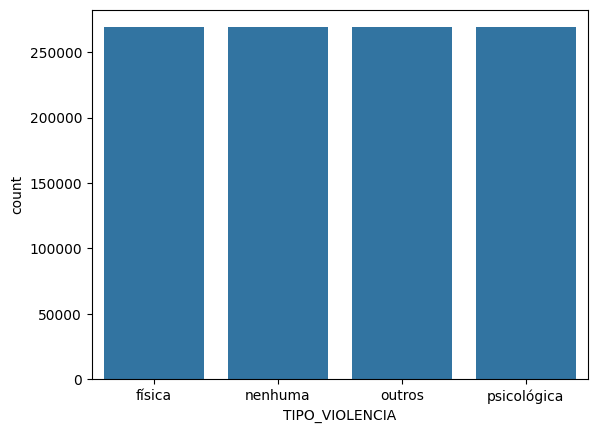

In [ ]:
sns.countplot(x=y_resampled)

In [ ]:
X__resampled.shape, y_resampled.shape , X.shape, y.shape

# aqui podemos ver que  saimos de 500 mil pra 1 milhao e 500 mil dados


((1076152, 59), (1076152,), (564432, 59), (564432,))

## Algoritimos de Aprendizagem - Pos balanceamento completo

In [ ]:
modelo = RandomForestClassifier(max_depth=10,
        n_estimators=100,
        random_state=42)
modelo.fit(X__resampled, y_resampled)

y_pred = modelo.predict(X_test)

print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred))

Relatório de Classificação:

              precision    recall  f1-score   support

      física       0.90      0.60      0.72    115303
     nenhuma       0.63      0.82      0.71     17859
      outros       0.45      0.83      0.58     21011
 psicológica       0.20      0.39      0.26     15157

    accuracy                           0.63    169330
   macro avg       0.54      0.66      0.57    169330
weighted avg       0.75      0.63      0.66    169330



In [ ]:
# Rodando o Random Forest com pessos

modelo = RandomForestClassifier(max_depth=20,
        min_samples_split=2,
        class_weight={'psicológica': 2, 'física': 1, 'nenhuma': 1, 'outros': 1.5},
        n_estimators=100,
        random_state=42)


modelo.fit(X__resampled, y_resampled)

y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      física       0.91      0.55      0.69    115303
     nenhuma       0.72      0.80      0.76     17859
      outros       0.47      0.83      0.60     21011
 psicológica       0.19      0.53      0.28     15157

    accuracy                           0.61    169330
   macro avg       0.57      0.68      0.58    169330
weighted avg       0.77      0.61      0.65    169330



Novamente a acuracia diminuiu bastante vamos tentar implementar os outros algoritimos para encontrar o que se sai melhor.

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    objective='multi:softmax',   # ou 'multi:softprob' se quiser as probabilidades
    num_class=4,                 # quantidade de classes que você temos
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# o xgb nao aceita rotulos como fisica,nenhuma,etc entao tive que transformar tudo em numero
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_resampled)
y_test_encoded = le.transform(y_test)

model.fit(X__resampled, y_train_encoded)

y_pred = model.predict(X_test)

print("Relatório de Classificação:\n")
print(classification_report(y_test_encoded, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:26:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.88      0.79      0.83    115303
           1       0.70      0.82      0.76     17859
           2       0.52      0.79      0.63     21011
           3       0.30      0.28      0.29     15157

    accuracy                           0.74    169330
   macro avg       0.60      0.67      0.63    169330
weighted avg       0.77      0.74      0.75    169330



Tivemos um aumento considerável na acurácia, porém ainda não conseguimos melhorar o recall e a precisão da classe psicológica. Tentaremos utilizar outros modelos para verificar qual se sai melhor.

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # 2 camadas ocultas
    max_iter=300, # numeros de iteraçoes
    random_state=42,
    early_stopping=True,
    verbose=True
)

mlp.fit(X__resampled, y_train_encoded)

y_pred = mlp.predict(X_test)

print(classification_report(y_test_encoded, y_pred))

Iteration 1, loss = 0.69826398
Validation score: 0.752016
Iteration 2, loss = 0.60806466
Validation score: 0.760668
Iteration 3, loss = 0.58725674
Validation score: 0.759302
Iteration 4, loss = 0.57699067
Validation score: 0.767247
Iteration 5, loss = 0.56953092
Validation score: 0.773370
Iteration 6, loss = 0.56398875
Validation score: 0.771019
Iteration 7, loss = 0.55999186
Validation score: 0.770991
Iteration 8, loss = 0.55659824
Validation score: 0.774299
Iteration 9, loss = 0.55350012
Validation score: 0.775582
Iteration 10, loss = 0.55081863
Validation score: 0.776074
Iteration 11, loss = 0.54861312
Validation score: 0.776622
Iteration 12, loss = 0.54675488
Validation score: 0.777115
Iteration 13, loss = 0.54498587
Validation score: 0.778955
Iteration 14, loss = 0.54310593
Validation score: 0.779484
Iteration 15, loss = 0.54160089
Validation score: 0.778481
Iteration 16, loss = 0.54063858
Validation score: 0.779243
Iteration 17, loss = 0.53913462
Validation score: 0.781194
Iterat

Os valores continuam muito ruins.

In [ ]:
import lightgbm as lgb


model_lgb = lgb.LGBMClassifier(
    objective='multiclass',
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    num_leaves = 63 ,
    scale_pos_weight=3,  # dizendo que a classe e mais importante

)
model_lgb.fit(X__resampled, y_resampled)

# 4. Avaliar
y_pred = model_lgb.predict(X_test)
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.513102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 1076152, number of used features: 59
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
              precision    recall  f1-score   support

      física       0.88      0.81      0.84    115303
     nenhuma       0.72      0.81      0.76     17859
      outros       0.55      0.76      0.64     21011
 psicológica       0.31      0.26      0.28     15157

    accuracy                           0.76    169330
   macro avg       0.61 

A acurácia aumentou bastante, porém os parâmetros da classe psicológica ainda estão muito baixos.Vamos tentar entender o problema.

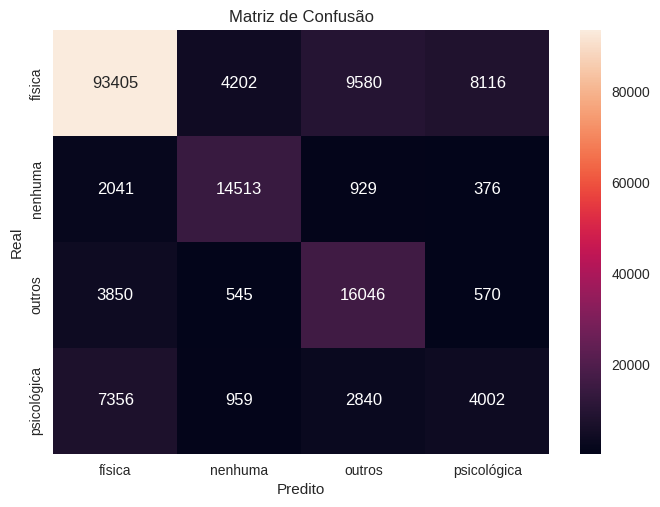

In [ ]:
# vou criar uma matriz de confunsão para tentar entender oque esta acontecendo
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=['física', 'nenhuma', 'outros', 'psicológica'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['física', 'nenhuma', 'outros', 'psicológica'], yticklabels=['física', 'nenhuma', 'outros', 'psicológica'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

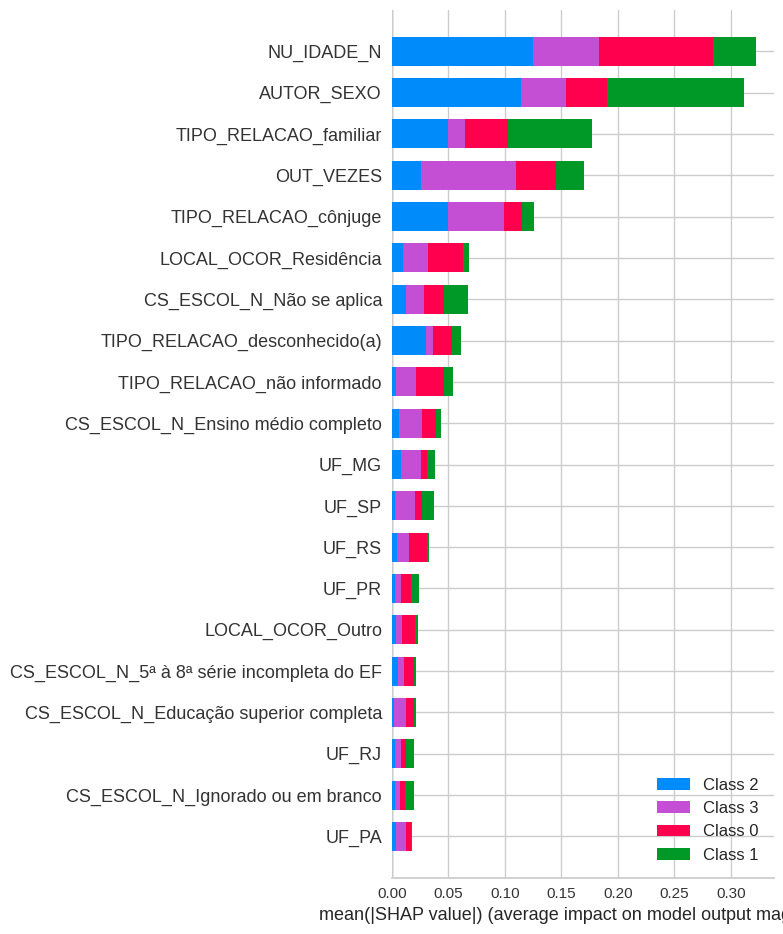

In [ ]:
# Vamos usar o shap para tentar entender quais atributos estão infuenciando o modelo a confunfir psicologica com fisica

import shap

explainer = shap.TreeExplainer(modelo)


shap_values = explainer.shap_values(X_test[:100])


shap.summary_plot(shap_values, X_test[:100], plot_type="bar")


Com os dados, foi identificado que um dos principais problemas da classe é a baixa representatividade, além da falta de informações que ajudem o modelo a identificar melhor o tipo de violência. Com isso, não foi possível aumentar significativamente os valores da classe psicológica

O próximo passo é tentar maximizar o resultado de cada modelo. Para isso, vamos implementar o GridSearch, que nos ajudará justamente a encontrar os melhores parâmetros.

## GridSearch - Maximizando o desempenho dos modelos

vamos usar o GridSearch para tentar encontrar o hiperparametros ideais de cada modelo.

In [ ]:
# vou agora tentar implementar o grid search pra tentar achar o parametro ideal do ramdom forest
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_macro',  # mais justo que accuracy
    cv=2,                # 2-fold cross-validation
    verbose=2,
    n_jobs=-1            # usa todos os núcleos do processador
)
# Executando o grid search
grid_search.fit(X__resampled, y_resampled)

melhores_parametros = grid_search.best_params_
melhor_modelo = grid_search.best_estimator_

# Avaliando o modelo com os melhores parâmetros
y_pred = melhor_modelo.predict(X_test)

print("Melhores parâmetros encontrados:")
print(melhores_parametros)

print("Relatório de Classificação com o Melhor Modelo:")
print(classification_report(y_test, y_pred))


Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Melhores parâmetros encontrados:
{'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Relatório de Classificação com o Melhor Modelo:
              precision    recall  f1-score   support

      física       0.89      0.74      0.81    115303
     nenhuma       0.70      0.82      0.75     17859
      outros       0.50      0.81      0.62     21011
 psicológica       0.26      0.33      0.29     15157

    accuracy                           0.72    169330
   macro avg       0.59      0.68      0.62    169330
weighted avg       0.77      0.72      0.73    169330



In [ ]:
# Tentando encontrar o parametro ideal do LGBMClassifier que obteve a melhor metrica ate o momento
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
# definindo o modelo bas
lgbm = LGBMClassifier(objective='multiclass', random_state=42)

# Definindo o grid de hiperparâmetros
param_grid = {
    'n_estimators': [200, 300],  # número de árvores
    'learning_rate': [0.01, 0.05, 0.1],  # taxa de aprendizado
    'num_leaves': [31, 63],           # número de folhas (complexidade das árvores)
}


# Configurando o GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=2,
    verbose=2,
    n_jobs=-1
)
# Executando o grid search
grid_search.fit(X__resampled, y_resampled)

melhores_parametros = grid_search.best_params_
melhor_modelo = grid_search.best_estimator_

# Avaliando o modelo com os melhores parâmetros
y_pred = melhor_modelo.predict(X_test)

print("Melhores parâmetros encontrados:")
print(melhores_parametros)

print("Relatório de Classificação com o Melhor Modelo:")
print(classification_report(y_test, y_pred))


Fitting 2 folds for each of 12 candidates, totalling 24 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.532488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 1076152, number of used features: 59
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Melhores parâmetros encontrados:
{'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 63}
Relatório de Classificação com o Melhor Modelo:
              precision    recall  f1-score   support

      física       0.87      0.82      0.85    115303
     nenhuma       0.73      0.81    

In [ ]:
from xgboost import XGBClassifier

# Instanciando o modelo base
modelo_xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Definindo o grid de hiperparâmetros
param_grid = {
    'n_estimators': [200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
}

# Configurando o GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=modelo_xgb,
    param_grid=param_grid,
    cv=5,  # validação cruzada com 5 folds
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
)

le = LabelEncoder()

y_train_encoded = le.fit_transform(y_resampled)
y_test_encoded = le.transform(y_test)



# Treinando com os dados
grid_search_xgb.fit(X__resampled, y_train_encoded)

# Exibindo os melhores parâmetros
print("Melhores parâmetros encontrados para o XGBClassifier:")
print(grid_search_xgb.best_params_)

# Avaliando o modelo
melhor_modelo_xgb = grid_search_xgb.best_estimator_
y_pred = melhor_modelo_xgb.predict(X_test)

print("Relatório de Classificação com o Melhor XGBClassifier:")
print(classification_report(y_test_encoded, y_pred))


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:38:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores parâmetros encontrados para o XGBClassifier:
{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Relatório de Classificação com o Melhor XGBClassifier:
              precision    recall  f1-score   support

           0       0.87      0.82      0.85    115303
           1       0.73      0.80      0.77     17859
           2       0.55      0.75      0.64     21011
           3       0.31      0.26      0.28     15157

    accuracy                           0.76    169330
   macro avg       0.62      0.66      0.63    169330
weighted avg       0.77      0.76      0.76    169330



Embora as redes neurais sejam modelos muito poderosos e amplamente utilizadas, optamos por desconsiderá-las, pois nos testes anteriores apresentaram um desempenho muito baixo e um tempo de execução bastante elevado em relação aos outros modelos.

## Salvando o modelo que mais se destacou

O modelo LGBM foi oque mais conseguiu valores mais lineares em relação aos outros modelos então vamos salvar ele para podermos ultilizar no nosso sistema web.

In [ ]:
from lightgbm import LGBMClassifier

# aplicando o LBBmClassifier
lgbm = LGBMClassifier( objective='multiclass',
    random_state=42,
    n_estimators=300,
    learning_rate=0.1,
    num_leaves = 63 ,
    scale_pos_weight=3,)
lgbm.fit(X_train, y_train)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.568563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 1076152, number of used features: 59
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


LGBMClassifier(n_estimators=200, num_leaves=63, objective='multiclass',
               random_state=42, scale_pos_weight=3)

In [ ]:

y_pred = lgbm.predict(X_test)

print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred))

Relatório de Classificação:

              precision    recall  f1-score   support

      física       0.88      0.81      0.84    115303
     nenhuma       0.72      0.81      0.76     17859
      outros       0.55      0.76      0.64     21011
 psicológica       0.31      0.26      0.28     15157

    accuracy                           0.76    169330
   macro avg       0.61      0.66      0.63    169330
weighted avg       0.77      0.76      0.76    169330



In [ ]:
import numpy as np

model_lgb = lgb.LGBMClassifier(
    objective='multiclass',
    random_state=42,
    n_estimators=300,
    learning_rate=0.1,
    num_leaves = 63 ,
    scale_pos_weight=3,  # dizendo que a classe 3 e mais importante

)

# juntatodos os dados pro treinamento final
X_violencia = np.concatenate((X__resampled, X_test), axis=0)
y_violencia = np.concatenate((y_resampled, y_test), axis=0)

model_lgb.fit(X_violencia, y_violencia)

import pickle

pickle.dump(model_lgb, open('model_lgb.sav', 'wb')) # salva o modelo treinado


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.616169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 1245482, number of used features: 59
[LightGBM] [Info] Start training from score -1.175748
[LightGBM] [Info] Start training from score -1.468155
[LightGBM] [Info] Start training from score -1.457228
[LightGBM] [Info] Start training from score -1.477617


# Conclusão do projeto

Este projeto teve como objetivo aplicar técnicas de aprendizado de máquina para classificar os tipos de violência sofridos por mulheres, com foco principal nas categorias física e psicológica, utilizando dados do sistema de notificações do SINAN.

Durante o processo foram feitas as seguinte etapas:

# 1. Pré-processamento e Preparação dos Dados

Nessa etapa realizamos o tratamento da base de dados, composta por mais de 1 milhão de colunas. Após uma análise exploratória, identificamos que muitos dos campos eram irrelevantes para o objetivo do projeto. Por isso:


* Selecionamos as variáveis mais relevantes para o nosso objetivo;

* Aplicamos a transformação de variáveis categóricas, como raça, escolaridade, local de ocorrência e relação com o agressor, convertendo-as para o tipo category com o objetivo de otimizar o uso de memória;

* Preenchemos valores nulos usando moda para colunas categóricas e mediana para colunas numéricas, de forma a manter a integridade dos dados;

* Criamos novas colunas como TIPO_VIOLENCIA (física, psicológica, outros) e TIPO_RELACAO, agrupando variáveis relacionadas para facilitar a análise e o treinamento dos modelos.

# 2. Tratamento de Desbalanceamento

Ao longo da análise,descobrimos um forte desbalanceamento entre as classes, com predominância de casos de violência física e sub-representação dos casos psicológicos. Para atenuar o problema, utilizamos o:

* SMOTE (Synthetic Minority Over-sampling Technique): técnica de oversampling que gera exemplos sintéticos para equilibrar a base;

A aplicação dessas técnicas teve como objetivo proporcionar uma representação mais justa das classes minoritárias, buscando melhorar a performance do modelo em categorias subnotificadas, como a violência psicológica.

# 3. Treinamento e Avaliação dos Modelos
Testamos diferentes algoritmos de aprendizado de máquina:

* Random Forest: teve excelente desempenho na identificação de casos de violência física, mas performance quase nula na classe psicológica;

* XGBoost (MaxGBoster) e LightGBM: ofereceram melhorias em termos de precisão e recall para a classe psicológica, embora ainda longe do ideal;

* Redes neurais chegaram a ser testadas, mas foram descartadas devido ao alto tempo de execução e baixo desempenho no contexto atual.

Utilizamos métricas como accuracy, precision, recall e f1-score, além da matriz de confusão, para avaliar a performance de cada modelo. O GridSearchCV foi usado para encontrar a melhor combinação de hiperparâmetros.

# 4. Análise dos Resultados
Apesar de melhorias com os modelos mais robustos e técnicas de balanceamento, a classe psicológica continuou apresentando baixo desempenho. Esse fato nos leva a algumas conclusões:

* Os dados disponíveis podem não conter informações suficientes ou claras para identificar padrões de violência psicológica;

* Esse tipo de violência pode demandar outras variáveis (como histórico clínico, linguagem usada no boletim, etc.), que não estão presentes na base.

# 5. Considerações Finais

Apesar dos grandes problemas enfrentados, conseguimos criar um modelo robusto e com desempenho equilibrado. No entanto, os desafios encontrados evidenciam a necessidade de:

* Bases mais completas e equilibradas;

* Melhor qualidade dos dados;

* Inclusão de dados complementares (como históricos psicológicos, registros de reincidência, etc.).


